# Assignment 4
Training a simple neural net for relation classification.

In [ ]:
import torch
import torch.nn as nn
!pip install transformers

import tensorflow as tf

import numpy as np
import math
from tabulate import tabulate

from sklearn.metrics import classification_report
from transformers import get_linear_schedule_with_warmup
from transformers import BertTokenizer
from transformers import BertForSequenceClassification
from transformers import AutoConfig, AutoModel


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')

print(device)

cuda


In [ ]:
# constants
batch_size = 8
epochs = 80
lr = 2e-5

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=10).to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In this assignment you are required to build a full training and testing pipeline for a neural relation classification (RC), using BERT.

The dataset that you will be working on is called SemEval Task 8 dataset (https://arxiv.org/pdf/1911.10422v1.pdf). The dataset contains only train and test split, but you are allowed to split the train dataset into dev if needed.


The two files (train and test) are available from the course git repository (https://github.com/kfirbar/nlp-course)


In this work we will use the hugingface framework for transformers training and inference. We recomand reading the documentation in https://huggingface.co/transformers/model_doc/bert.html#bertforsequenceclassification *before* you start coding. 


**Task 1:** Write a funtion *read_data* for reading the data from a single file (either train or test). This function recieves a filepath and returns a list of sentence. Every sentence is encoded as a tuple, where the first element is the sentence string and the second the label (also represented as a string). 

In [ ]:
!git clone https://github.com/kfirbar/nlp-course

fatal: destination path 'nlp-course' already exists and is not an empty directory.


In [ ]:
def read_data(filepath):
    # TODO... write your code accordingly
    with open(filepath) as file:
        output = file.readlines()

    STEP = 4
    sentences_indices = np.arange(0, len(output), STEP)
    labels_indices = np.arange(1, len(output), STEP)

    # for each sentence (filtered by known indices) - remove '\n' and ignore leading and trailing \" chars  
    sentences = list(map(lambda i: str(output[i].split('\t')[1].replace('\n', '')[1:-1]), sentences_indices))
    labels = list(map(lambda i: output[i].replace('\n', ''), labels_indices))
    data = list(zip(sentences, labels))

    return data


train = read_data('/content/nlp-course/TRAIN_FILE.TXT')
test = read_data('/content/nlp-course/TEST_FILE_FULL.TXT')

In [ ]:
train[0]

('The system as described above has its greatest application in an arrayed <e1>configuration</e1> of antenna <e2>elements</e2>.',
 'Component-Whole(e2,e1)')

Pytorch require the labels to be integers. Create a mapper (dictionary) from the string labels to integers (starting zero). 

In [ ]:
def create_label_mapper(data, remove_entities=False):
    # TODO... write your code accordingly
    labels = [t[1] for t in data]  # 1 is the position of each label in the list of t tuples

    # if we want to remove the (e1,e2) and (e2,e1) strings from the labels
    if remove_entities == True:
        labels = list(map(lambda l: l.replace('(e1,e2)', '').replace('(e2,e1)', ''), labels))

    labels_set = set(labels)  # get unique labels
    labels_dict = dict(zip(labels_set, range(len(labels_set))))

    return labels_dict


labels_dict = create_label_mapper(train, remove_entities=True)
labels_dict

{'Cause-Effect': 7,
 'Component-Whole': 6,
 'Content-Container': 5,
 'Entity-Destination': 1,
 'Entity-Origin': 3,
 'Instrument-Agency': 9,
 'Member-Collection': 4,
 'Message-Topic': 8,
 'Other': 0,
 'Product-Producer': 2}

**Task 2:** Write a function *prepare_data* that takes one of the [train, test] datasets and converts each pair of (words, labels) to a pair of indexes. The function also aggregates the samples into batches. BERT uses pretrained tokenization and embedding. you can access the tokenization and indexing using the BertTokenizer class.

In [ ]:
def prepare_data(data, tokenizer, labels_dict, batch_size=batch_size, remove_entities=True):
    data_sequences = []
    # TODO - your code...
    number_of_batches = math.ceil(len(data) / batch_size)


    input_ids, attention_masks, labels = [], [], []

    for batch in range(number_of_batches):
        batch_sentences = []
        batch_labels = []

        batch_data_seq = []
        batch_start_idx = batch * batch_size
        batch_end_idx = batch_start_idx + batch_size

        if batch_end_idx > len(data):
            batch_end_idx = len(data)

        for i in range(batch_start_idx, batch_end_idx):
            current_sentence = data[i]
            current_text = current_sentence[0]

            current_label = current_sentence[1]
            if remove_entities == True:
                current_label = current_label.replace('(e1,e2)', '').replace('(e2,e1)', '')
                current_text = current_text.replace('<e1>', '').replace('<e2>', '').replace('</e1>', '').replace('</e2>', '')

            current_label_idx = labels_dict[current_label]

            batch_sentences.append(current_text)
            batch_labels.append(current_label_idx)


        batch_tokend = tokenizer(batch_sentences, padding=True, truncation=True, return_tensors="pt")            

        b_input_ids, b_attn_mask = batch_tokend['input_ids'], batch_tokend['attention_mask']            

        current_sample = (b_input_ids, b_attn_mask, batch_labels)

        data_sequences.append(current_sample)

    return data_sequences
    # return input_ids, attention_masks, labels



train_sequences = prepare_data(train, tokenizer, labels_dict)
test_sequences = prepare_data(test, tokenizer, labels_dict)

**Task 3:** In this part we classify the sentences using the BertForSequenceClassification model. To save resources, we initialize the optimizer with the final layer of the model. You are also allowed to change the learning rate.

In [ ]:
def get_parameters(params):

    layers = []

    for name, param in params:   
        param.requires_grad = 'classifier' in name
        layers.append(param)

    return layers


**Task 4:** Write a training loop, which takes a BertForSequenceClassification model and number of epochs to train on. The loss is always CrossEntropyLoss and the optimizer is always Adam. You are allowed to split the train to train and dev sets.

In [ ]:
from transformers import BertForSequenceClassification


def train_loop(model, n_epochs, train_data, dev_data, lr=0.0001):
    # Loss function
    criterion = nn.CrossEntropyLoss()
    # optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    optimizer = torch.optim.Adam(get_parameters(model.named_parameters()), lr=lr)

    model.train()


    for e in range(1, n_epochs + 1):
        # TODO - your code goes here...

        for step, batch in enumerate(train_data):

            b_input_ids, b_attn_mask, b_labels = tuple(t for t in batch)
            
            b_labels = torch.tensor(b_labels).to(device)
            model.zero_grad()

            
            logits = model(b_input_ids.to(device), b_attn_mask.to(device))
            logits = logits['logits']

            # Compute loss and accumulate the loss values
            loss = criterion(logits, b_labels)

            # Perform a backward pass to calculate gradients
            loss.backward()

            # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update parameters and the learning rate
            optimizer.step()


        print(f"epoch number: {e} is done")

    return model

**Task 5:** write an evaluation loop on a trained model, using the dev and test datasets. This function print the true positive rate (TPR), also known as Recall and the opposite to false positive rate (FPR), also known as precision, of each label seperately (10 labels in total), and for all labels together. The caption argument for the function should be served for printing, so that when you print include it as a prefix.

In [ ]:
def evaluate(model, test_data, prefix="TEST"):

    # Put model in evaluation mode
    model.eval()

    # Tracking variables 
    predictions , true_labels, = [], []
    pred_labels = []

    # Predict 
    for batch in test_data:
        # Add batch to GPU
        b_input_ids, b_attn_mask, b_labels = tuple(t for t in batch)
        
        b_labels = torch.tensor(b_labels).to(device)

        # Telling the model not to compute or store gradients, saving memory and 
        # speeding up prediction
        with torch.no_grad():
            # Forward pass, calculate logit predictions

            logits = model(b_input_ids.to(device), b_attn_mask.to(device))
            logits = logits['logits']

            # Move logits and labels to CPU
            logits = logits.detach().cpu().numpy()
            label_ids = b_labels.to('cpu').numpy()
            
            # Store predictions and true labels
            predictions.append(logits)
            true_labels.append(label_ids)


    for i in range(len(true_labels)):
        pred_labels.append(np.argmax(predictions[i], axis=1))


    pred_labels = [val for sublist in pred_labels for val in sublist]
    true_labels = [val for sublist in true_labels for val in sublist]

    return pred_labels, true_labels

In [ ]:
def calc_precision_recall(pred_labels, true_labels):

    results_dict = dict.fromkeys(labels_dict.keys())

    idx_to_labels_dict = {value:key for key, value in labels_dict.items()}

    rows =[]
    total_precision = 0
    total_recall = 0


    for key in results_dict.keys():
        results_dict[key] = {"TP": 0, "FP": 0, "FN": 0}

    for i in range(len(pred_labels)):
        pred_label = pred_labels[i]
        true_label = true_labels[i]

        if pred_label == true_label:
            TP_label = idx_to_labels_dict[pred_label]
            results_dict[TP_label]["TP"] +=1
        else:
            FP_label = idx_to_labels_dict[pred_label]
            FN_label = idx_to_labels_dict[true_label]

            results_dict[FP_label]["FP"] +=1
            results_dict[FN_label]["FN"] +=1

    for label in results_dict.keys():
        TP = results_dict[label]["TP"]
        FP = results_dict[label]["FP"]
        FN = results_dict[label]["FN"]

        precision = TP/(TP+FP)
        recall = TP/(TP+FN)

        rows.append([label, precision, recall])

        total_precision += precision
        total_recall += recall
    
    total_precision /= len(results_dict)
    total_recall /= len(results_dict)

    rows.append(["All Together", total_precision, total_recall])

    print(tabulate(rows, headers=['Label', 'Precision', 'Recall'], tablefmt='grid'))


In [ ]:
model = train_loop(model, n_epochs=epochs, train_data=train_sequences, dev_data=None, lr = lr)

epoch number: 1 is done
epoch number: 2 is done
epoch number: 3 is done
epoch number: 4 is done
epoch number: 5 is done
epoch number: 6 is done
epoch number: 7 is done
epoch number: 8 is done
epoch number: 9 is done
epoch number: 10 is done
epoch number: 11 is done
epoch number: 12 is done
epoch number: 13 is done
epoch number: 14 is done
epoch number: 15 is done
epoch number: 16 is done
epoch number: 17 is done
epoch number: 18 is done
epoch number: 19 is done
epoch number: 20 is done
epoch number: 21 is done
epoch number: 22 is done
epoch number: 23 is done
epoch number: 24 is done
epoch number: 25 is done
epoch number: 26 is done
epoch number: 27 is done
epoch number: 28 is done
epoch number: 29 is done
epoch number: 30 is done
epoch number: 31 is done
epoch number: 32 is done
epoch number: 33 is done
epoch number: 34 is done
epoch number: 35 is done
epoch number: 36 is done
epoch number: 37 is done
epoch number: 38 is done
epoch number: 39 is done
epoch number: 40 is done
epoch num

In [ ]:
pred_labels, true_labels = evaluate(model.to(device), test_sequences)

In [ ]:
calc_precision_recall(pred_labels, true_labels)

{'Other': {'TP': 354, 'FP': 1439, 'FN': 100}, 'Entity-Destination': {'TP': 15, 'FP': 11, 'FN': 277}, 'Product-Producer': {'TP': 4, 'FP': 10, 'FN': 227}, 'Entity-Origin': {'TP': 12, 'FP': 5, 'FN': 246}, 'Member-Collection': {'TP': 14, 'FP': 5, 'FN': 219}, 'Content-Container': {'TP': 76, 'FP': 82, 'FN': 116}, 'Component-Whole': {'TP': 95, 'FP': 99, 'FN': 217}, 'Cause-Effect': {'TP': 208, 'FP': 276, 'FN': 120}, 'Message-Topic': {'TP': 3, 'FP': 2, 'FN': 258}, 'Instrument-Agency': {'TP': 3, 'FP': 4, 'FN': 153}}
+--------------------+-------------+-----------+
| Label              |   Precision |    Recall |
+====================+=============+===========+
| Other              |    0.197434 | 0.779736  |
+--------------------+-------------+-----------+
| Entity-Destination |    0.576923 | 0.0513699 |
+--------------------+-------------+-----------+
| Product-Producer   |    0.285714 | 0.017316  |
+--------------------+-------------+-----------+
| Entity-Origin      |    0.705882 | 0.0465116 

**Task 6:** In this part we'll improve the model accuracy by using a method called "entity markers - Entity start". The main idea of this approch is to add special markers ([e1], [\e1], ...) before and after each of the tagged entities. instead of using the CLS toekn for clasification, we will use the concatination of the embedding of [e1] and [e2] as shown in the image below. The complete method is described in details in the following paper - https://arxiv.org/pdf/1906.03158.pdf (specifically in Section 3.2). To use this method we'll need to create a new data load and a new model.

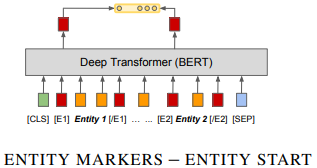

The new methods require the usage of special tokens. The following code will add the required tokens.

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

tokenizer_MTB = tokenizer

tokenizer_MTB.add_tokens(['<e1>', '</e1>', '<e2>', '</e2>'])

4

In [ ]:
n_epoch_MTB = 80
lr_MTB = 2e-5
batch_size_MTB = 8

Create a new dataloader that add entity markers to the dataset and return their indexes as part of the new sample (the expected sample should be (s, l, i) where s is the sentence embedding, l is the label, and i is a touple with the indexes of the start entities)

In [ ]:
labels_dict_MTB = create_label_mapper(train, remove_entities=True)

In [ ]:
def prepare_data_MTB(data, tokenizer, batch_size=batch_size_MTB):
    
    data_sequences = []
    # TODO - your code...
    number_of_batches = math.ceil(len(data) / batch_size)

    e1_start=tokenizer.added_tokens_encoder['<e1>']
    e2_start=tokenizer.added_tokens_encoder['<e2>']

    input_ids, attention_masks, labels, e1_e2_idxs = [], [], [], []

    for batch in range(number_of_batches):
        batch_sentences = []
        batch_labels = []

        batch_start_idx = batch * batch_size
        batch_end_idx = batch_start_idx + batch_size

        if batch_end_idx > len(data):
            batch_end_idx = len(data)

        for i in range(batch_start_idx, batch_end_idx):
            current_sen_label = data[i]
            current_sentence = current_sen_label[0]

            current_label = current_sen_label[1]
            current_label = current_label.replace('(e1,e2)', '').replace('(e2,e1)', '')
            
            current_label_idx = labels_dict_MTB[current_label]


            batch_sentences.append(current_sentence)
            batch_labels.append(current_label_idx)


        batch_tokend = tokenizer(batch_sentences, max_length = 256, padding='max_length', return_tensors="pt", add_special_tokens=True)            

        b_input_ids, b_attn_mask = batch_tokend['input_ids'], batch_tokend['attention_mask']            

        batch_e1 = (b_input_ids ==e1_start).nonzero()[:,1] 
        batch_e2 = (b_input_ids ==e2_start).nonzero()[:,1] 

        e1_e2_idxs = (batch_e1, batch_e2)

        current_sample = ((b_input_ids, b_attn_mask), batch_labels, e1_e2_idxs)

        
        data_sequences.append(current_sample)
    return data_sequences


train_sequences_MTB = prepare_data_MTB(train, tokenizer_MTB)
test_sequences_MTB = prepare_data_MTB(test, tokenizer_MTB)

Create a new model that uses the "entity markers - Entity start" method.

In [ ]:
class MTB(nn.Module):
    
    def __init__(self, base_model_name):
        super(MTB, self).__init__()

        config = AutoConfig.from_pretrained(base_model_name)
        config.num_labels = 10

        self.bert = AutoModel.from_pretrained(base_model_name, config=config)

        self.bert.resize_token_embeddings(len(tokenizer_MTB))

        # TODO - your code...

        self.num_labels = config.num_labels
        self.hidden_size = config.hidden_size

        self.classifier = nn.Linear(self.hidden_size * 2, self.num_labels)



    def forward(self, input, index):
        
        (input_ids, attention_mask) = input
        e1 = torch.tensor(index[0])
        e2 = torch.tensor(index[1])

        e1 =  e1.unsqueeze(-1)
        e2 =  e2.unsqueeze(-1)

        outputs = self.bert(input_ids, attention_mask=attention_mask, output_hidden_states=True)

        hidden_states_last = outputs.hidden_states[12].to(device)
        
        e1_idxes = (e1.repeat(1,self.hidden_size).to(device)).unsqueeze(1)
        e2_idxes = (e2.repeat(1,self.hidden_size).to(device)).unsqueeze(1)


        e1_hidden_states = torch.gather(hidden_states_last, 1, e1_idxes)
        e1_hidden_states = torch.squeeze(e1_hidden_states, dim=1)

        e2_hidden_states = torch.gather(hidden_states_last, 1, e2_idxes)
        e2_hidden_states = torch.squeeze(e2_hidden_states,dim=1)
        
        e1_e2_hidden_states = torch.cat((e1_hidden_states, e2_hidden_states), dim=1)

        output = self.classifier(e1_e2_hidden_states)
        return output



In [ ]:
from transformers import BertForSequenceClassification


def train_loop_MTB(model, n_epochs, train_data, dev_data, lr=0.0001):

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(get_parameters(model.named_parameters()), lr=lr)

    model.train()
    for e in range(1, n_epochs + 1):
        # TODO - your code goes here...

        total_train_loss = 0

        for step, batch in enumerate(train_data):
            (b_input_ids, b_attn_mask), b_labels, e1_e2_idxs  = tuple(t for t in batch)
            
            b_labels = torch.tensor(b_labels).to(device)

            model.zero_grad()

            logits = model((b_input_ids.to(device), b_attn_mask.to(device)), e1_e2_idxs)

            # Compute loss and accumulate the loss values
            loss = criterion(logits, b_labels)

            # Perform a backward pass to calculate gradients
            loss.backward()

            # Update parameters and the learning rate
            optimizer.step()


        print(f"epoch number: {e} is done")

    return model

In [ ]:
def evaluate_MTB(model, test_data, prefix="TEST"):

    # Put model in evaluation mode
    model.eval()

    # Tracking variables 
    predictions , true_labels, = [], []
    pred_labels = []

    # Predict 
    for batch in test_data:
        # Add batch to GPU
        (b_input_ids, b_attn_mask), b_labels, e1_e2_idxs = tuple(t for t in batch)
        
        b_labels = torch.tensor(b_labels).to(device)

        # Telling the model not to compute or store gradients, saving memory and 
        # speeding up prediction
        with torch.no_grad():
            # Forward pass, calculate logit predictions

            logits = model((b_input_ids.to(device), b_attn_mask.to(device)), e1_e2_idxs)
            # logits = logits['logits']

            logits = torch.log_softmax(logits, dim=1)

            # Move logits and labels to CPU
            logits = logits.detach().cpu().numpy()
            label_ids = b_labels.to('cpu').numpy()
            
            # Store predictions and true labels
            predictions.append(logits)
            true_labels.append(label_ids)


    for i in range(len(true_labels)):
        pred_labels.append(np.argmax(predictions[i], axis=1))


    pred_labels = [val for sublist in pred_labels for val in sublist]
    true_labels = [val for sublist in true_labels for val in sublist]

    return pred_labels, true_labels

Use the new dataloader and model to train and evaluate the new model as in task 4 and 5

In [ ]:
model_MTB = MTB('bert-base-uncased').to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
model_MTB = train_loop_MTB(model_MTB, n_epoch_MTB, train_sequences_MTB, dev_data=None)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


epoch number: 1 is done
epoch number: 2 is done
epoch number: 3 is done
epoch number: 4 is done
epoch number: 5 is done
epoch number: 6 is done
epoch number: 7 is done
epoch number: 8 is done
epoch number: 9 is done
epoch number: 10 is done
epoch number: 11 is done
epoch number: 12 is done
epoch number: 13 is done
epoch number: 14 is done
epoch number: 15 is done
epoch number: 16 is done
epoch number: 17 is done
epoch number: 18 is done
epoch number: 19 is done
epoch number: 20 is done
epoch number: 21 is done
epoch number: 22 is done
epoch number: 23 is done
epoch number: 24 is done
epoch number: 25 is done
epoch number: 26 is done
epoch number: 27 is done
epoch number: 28 is done
epoch number: 29 is done
epoch number: 30 is done
epoch number: 31 is done
epoch number: 32 is done
epoch number: 33 is done
epoch number: 34 is done
epoch number: 35 is done
epoch number: 36 is done
epoch number: 37 is done
epoch number: 38 is done
epoch number: 39 is done
epoch number: 40 is done
epoch num

In [ ]:
pred_labels_MTB, true_labels_MTB = evaluate_MTB(model_MTB, test_sequences_MTB)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [ ]:
calc_precision_recall(pred_labels_MTB, true_labels_MTB)

{'Other': {'TP': 239, 'FP': 340, 'FN': 215}, 'Entity-Destination': {'TP': 219, 'FP': 41, 'FN': 73}, 'Product-Producer': {'TP': 169, 'FP': 82, 'FN': 62}, 'Entity-Origin': {'TP': 169, 'FP': 50, 'FN': 89}, 'Member-Collection': {'TP': 180, 'FP': 37, 'FN': 53}, 'Content-Container': {'TP': 160, 'FP': 41, 'FN': 32}, 'Component-Whole': {'TP': 227, 'FP': 48, 'FN': 85}, 'Cause-Effect': {'TP': 290, 'FP': 52, 'FN': 38}, 'Message-Topic': {'TP': 198, 'FP': 50, 'FN': 63}, 'Instrument-Agency': {'TP': 95, 'FP': 30, 'FN': 61}}
+--------------------+-------------+----------+
| Label              |   Precision |   Recall |
+====================+=============+==========+
| Other              |    0.412781 | 0.526432 |
+--------------------+-------------+----------+
| Entity-Destination |    0.842308 | 0.75     |
+--------------------+-------------+----------+
| Product-Producer   |    0.673307 | 0.731602 |
+--------------------+-------------+----------+
| Entity-Origin      |    0.771689 | 0.655039 |
+----

**Good luck!**